In [62]:
import numpy as np
import pandas as pd
import os
import PIL
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import shutil
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
summ = pd.read_csv('Chest_xray_Corona_dataset_Summary.csv')
meta = pd.read_csv('Chest_xray_Corona_Metadata.csv')
#null데이터 0으로 만들어줌
meta.fillna('0', inplace = True)
meta.isnull().sum()

print(meta)

#test와 train 데이터 나눔
train_data = meta[meta['Dataset_type']=='TRAIN']
test_data = meta[meta['Dataset_type']=='TEST']

#test, train 나눈 데이터 새로운 csv에 저장
#train_data.to_csv('train_data_corona.csv')
#test_data.to_csv('test_data_corona.csv')

      Unnamed: 0            X_ray_image_name     Label Dataset_type  \
0              0           IM-0128-0001.jpeg    Normal        TRAIN   
1              1           IM-0127-0001.jpeg    Normal        TRAIN   
2              2           IM-0125-0001.jpeg    Normal        TRAIN   
3              3           IM-0122-0001.jpeg    Normal        TRAIN   
4              4           IM-0119-0001.jpeg    Normal        TRAIN   
...          ...                         ...       ...          ...   
5905        5928  person1637_virus_2834.jpeg  Pnemonia         TEST   
5906        5929  person1635_virus_2831.jpeg  Pnemonia         TEST   
5907        5930  person1634_virus_2830.jpeg  Pnemonia         TEST   
5908        5931  person1633_virus_2829.jpeg  Pnemonia         TEST   
5909        5932  person1632_virus_2827.jpeg  Pnemonia         TEST   

     Label_2_Virus_category Label_1_Virus_category  
0                         0                      0  
1                         0              

In [6]:
train_df=pd.read_csv('train_data_corona.csv')
test_df=pd.read_csv('test_data_corona.csv')

In [8]:
train_df.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,0,0
1,IM-0127-0001.jpeg,Normal,TRAIN,0,0
2,IM-0125-0001.jpeg,Normal,TRAIN,0,0
3,IM-0122-0001.jpeg,Normal,TRAIN,0,0
4,IM-0119-0001.jpeg,Normal,TRAIN,0,0


In [9]:
test_df.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0021-0001.jpeg,Normal,TEST,0,0
1,IM-0019-0001.jpeg,Normal,TEST,0,0
2,IM-0017-0001.jpeg,Normal,TEST,0,0
3,IM-0016-0001.jpeg,Normal,TEST,0,0
4,IM-0015-0001.jpeg,Normal,TEST,0,0


In [10]:
#x-ray 이미지 데이터 불러오기
train_img='./Coronahack-Chest-XRay-Dataset/train'
test_img='./Coronahack-Chest-XRay-Dataset/test'

In [14]:
#폐렴과 일반데이터 확인
train_df['Label'].value_counts()

Pnemonia    3944
Normal      1342
Name: Label, dtype: int64

In [15]:
#사진의 병명,수 확인
train_df['Label_2_Virus_category'].value_counts()

0                5217
COVID-19           58
Streptococcus       5
SARS                4
ARDS                2
Name: Label_2_Virus_category, dtype: int64

In [81]:
Pneumonia  = train_df[train_df['Label']=='Pnemonia']  
Normal = train_df[train_df['Label']=='Normal']

print('covid19 shape: ',Pneumonia.shape)
print('covid19 shape: ',Normal.shape)

covid19 shape:  (633, 5)
covid19 shape:  (212, 5)


In [19]:
train_df, valid_df = train_test_split(train_df, train_size=0.8, random_state=0)

In [20]:
print(f"Negative and positive values of train: {train_df['Label'].value_counts()}")
print(f"Negative and positive values of validation: {valid_df['Label'].value_counts()}")
print(f"Negative and positive values of test: {test_df['Label'].value_counts()}")

Negative and positive values of train: Pnemonia    633
Normal      212
Name: Label, dtype: int64
Negative and positive values of validation: Pnemonia    162
Normal       50
Name: Label, dtype: int64
Negative and positive values of test: Pnemonia    390
Normal      234
Name: Label, dtype: int64


In [21]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [23]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_df, directory=train_img, x_col='X_ray_image_name', 
                                              y_col='Label', target_size=(224,224), batch_size=64, 
                                               class_mode='binary')
valid_gen = test_datagen.flow_from_dataframe(dataframe = valid_df, directory=train_img, x_col='X_ray_image_name',
                                             y_col='Label', target_size=(224,224), batch_size=64, 
                                            class_mode='binary')
test_gen = test_datagen.flow_from_dataframe(dataframe = test_df, directory=test_img, x_col='X_ray_image_name', 
                                            y_col='Label', target_size=(224,224), batch_size=64,
                                             class_mode='binary')

Found 845 validated image filenames belonging to 2 classes.
Found 212 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [24]:
import tensorflow as tf

base_model = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape = (224,224,3),
                                                     include_top=False)
for layer in base_model.layers:
    layer.trainable = False

Metal device set to: Apple M1


2022-09-21 18:35:22.013328: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-21 18:35:22.014723: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


94668760/94668760 [==============================] - 3s 0us/step


In [25]:
model = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [26]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("covid_classifier_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]


In [27]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [31]:
history = model.fit(train_gen, 
                    validation_data=valid_gen, epochs=100, 
                    callbacks=[callbacks])

Epoch 1/100
14/14 [==============================] - 14s 902ms/step - loss: 0.2199 - accuracy: 0.9302 - val_loss: 0.2628 - val_accuracy: 0.8868 - lr: 5.0000e-04
Epoch 2/100
14/14 [==============================] - 12s 835ms/step - loss: 0.2186 - accuracy: 0.9278 - val_loss: 0.2713 - val_accuracy: 0.8821 - lr: 5.0000e-04
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.1945 - accuracy: 0.9373
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
14/14 [==============================] - 13s 873ms/step - loss: 0.1945 - accuracy: 0.9373 - val_loss: 0.3194 - val_accuracy: 0.8726 - lr: 5.0000e-04
Epoch 4/100
14/14 [==============================] - 12s 841ms/step - loss: 0.1790 - accuracy: 0.9538 - val_loss: 0.2111 - val_accuracy: 0.9292 - lr: 2.5000e-04
Epoch 5/100
14/14 [==============================] - 13s 892ms/step - loss: 0.1891 - accuracy: 0.9385 - val_loss: 0.1764 - val_accuracy: 0.9387 - lr: 2.5000e-04
Epoch 6/100
14/14 [=================

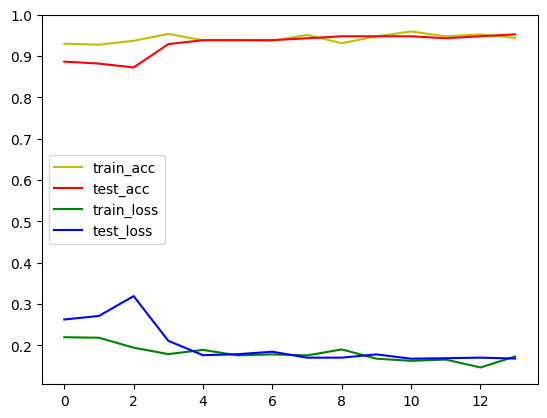

In [60]:
plt.plot(history.history['accuracy'],'y')
plt.plot(history.history['val_accuracy'],'r')
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.legend(['train_acc', 'test_acc','train_loss', 'test_loss'], loc='center left')
plt.show()
